In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap
from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_homo
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

# Load Data

In [2]:
raw_df = pd.read_table('./layerwise.txt')
avail_df = raw_df[raw_df['xenium:cell:layer'].isna()==False]
avail_df.set_index("Object ID", inplace = True)
adata_df = avail_df[avail_df.columns[pd.Series(avail_df.columns).str.startswith('xenium:cell_transcript:')].tolist()]
adata_df.columns = [t.replace('xenium:cell_transcript:','') for t in adata_df.columns.tolist()]

/tmp/ipykernel_202215/762853516.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_table('./layerwise.txt')


In [3]:
avail_df.loc[avail_df["xenium:cell:layer"] == 0, "layer"] = '0'
avail_df.loc[(0 < avail_df["xenium:cell:layer"]) & (avail_df["xenium:cell:layer"] <= 1.0), "layer"] = '1'
avail_df.loc[1 < avail_df["xenium:cell:layer"], "layer"] = '2'

/tmp/ipykernel_202215/415130903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avail_df.loc[avail_df["xenium:cell:layer"] == 0, "layer"] = '0'


In [4]:
adata = ad.AnnData(csr_matrix(adata_df.values), dtype=np.float32)
adata.obs_names = adata_df.index
adata.var_names = adata_df.columns
adata.obs.index = adata.obs.index.astype(str)
adata.obsm["spatial"] = avail_df[['Centroid X µm','Centroid Y µm']].to_numpy()
adata.obs["layer"] = avail_df['layer'].astype('category')

# Preprocessing

In [5]:
# sc.pp.filter_cells(adata, min_genes=10) #get rid of cells with fewer than 200 genes
# sc.pp.filter_genes(adata, min_cells=10) #get rid of genes that are found in fewer than 3 cells

In [6]:
# adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [7]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)

In [8]:
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
# adata = adata[adata.obs.pct_counts_mt < 20]

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(adata) #change to log counts

/opt/anaconda3/envs/st2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values

In [11]:
adata.raw = adata #save raw data before processing values and further filtering
adata = adata[:, adata.var.highly_variable] #filter highly variable

In [12]:
# sc.pp.regress_out(adata, ['total_counts']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
# sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
# sc.pp.pca(adata)

In [13]:
# sc.pl.pca_variance_ratio(adata, log=True)

In [14]:
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5)
# sc.tl.leiden(adata, resolution = 0.25)
# sc.tl.umap(adata)

In [15]:
# sc.pl.umap(
#     adata,
#     color=[
#         "total_counts",
#         "n_genes_by_counts",
#         "layer",
#     ],
#     wspace=0.4,
# )

In [16]:
sc.tl.rank_genes_groups(adata, 'layer', method='wilcoxon')

/opt/anaconda3/envs/st2/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [17]:
results = adata.uns['rank_genes_groups']
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))
adata.uns['markers'] = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])
# adata.uns['markers'] = markers #save marker df to uns

         Falling back to preprocessing with `sc.pp.pca` and default params.


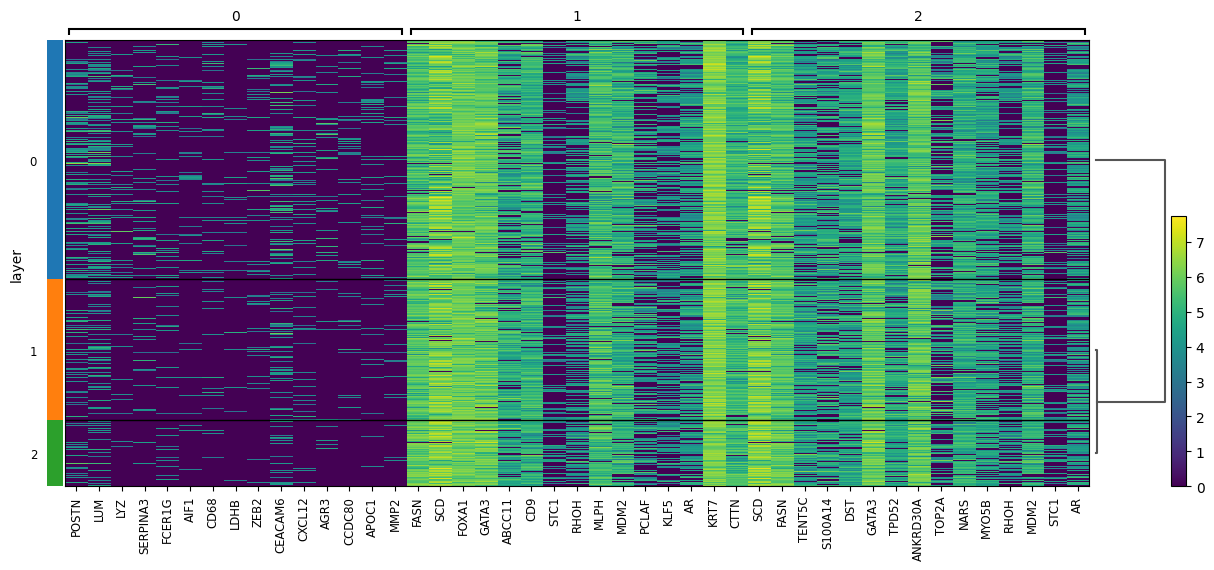

In [18]:
sc.tl.dendrogram(adata, groupby='layer')
sc.tl.rank_genes_groups(adata, "layer", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="012", n_genes=15, groupby="layer")

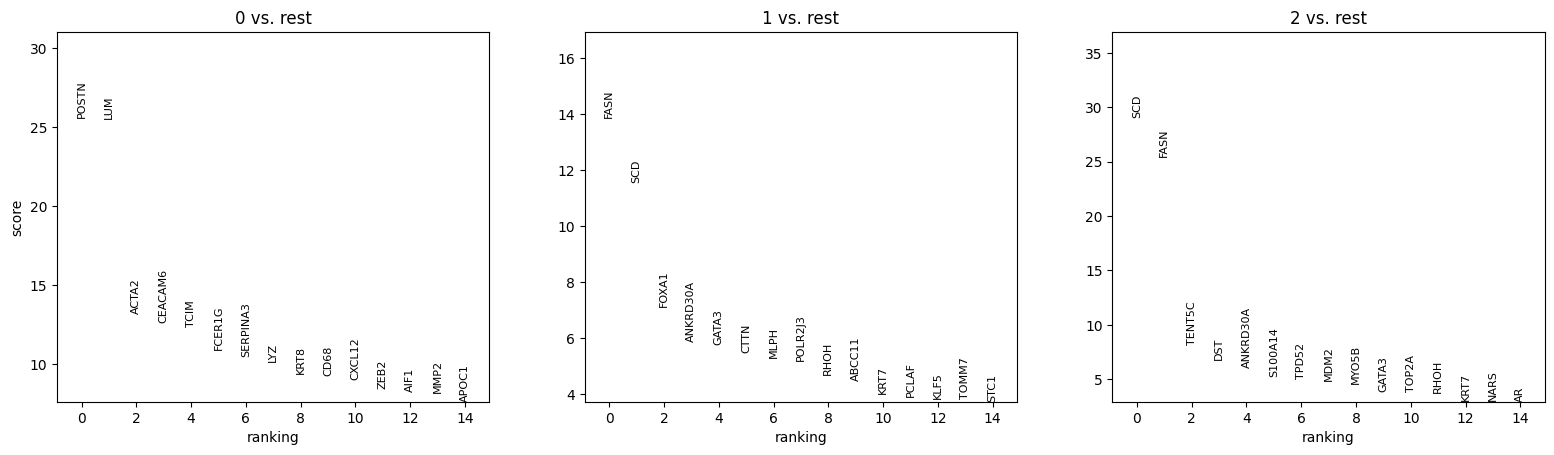

In [19]:
sc.tl.rank_genes_groups(adata, 'layer', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [40]:
top_gene_num = 15

In [41]:
top_gene_list = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(top_gene_num)
top_gene_list

,0,1,2
0,POSTN,FASN,SCD
1,LUM,SCD,FASN
2,ACTA2,FOXA1,TENT5C
3,CEACAM6,ANKRD30A,DST
4,TCIM,GATA3,ANKRD30A
5,FCER1G,CTTN,S100A14
6,SERPINA3,MLPH,TPD52
7,LYZ,POLR2J3,MDM2
8,KRT8,RHOH,MYO5B
9,CD68,ABCC11,GATA3


In [42]:
marker_genes = list(set(np.array(top_gene_list).reshape(-1)))
len(marker_genes)

39

/opt/anaconda3/envs/st2/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


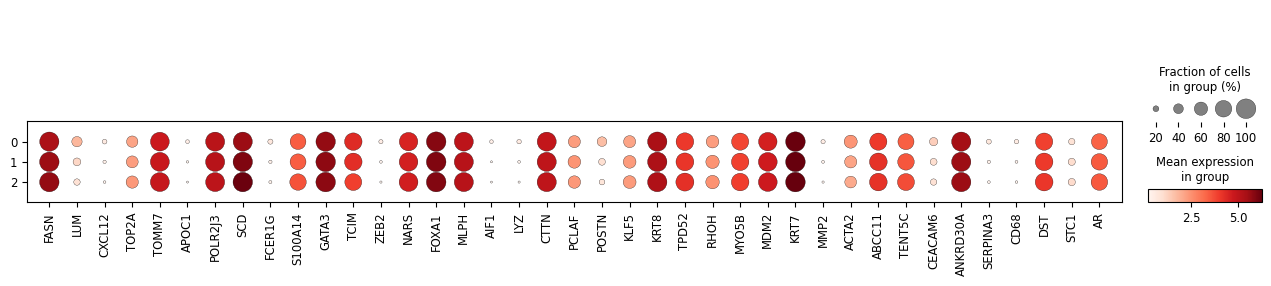

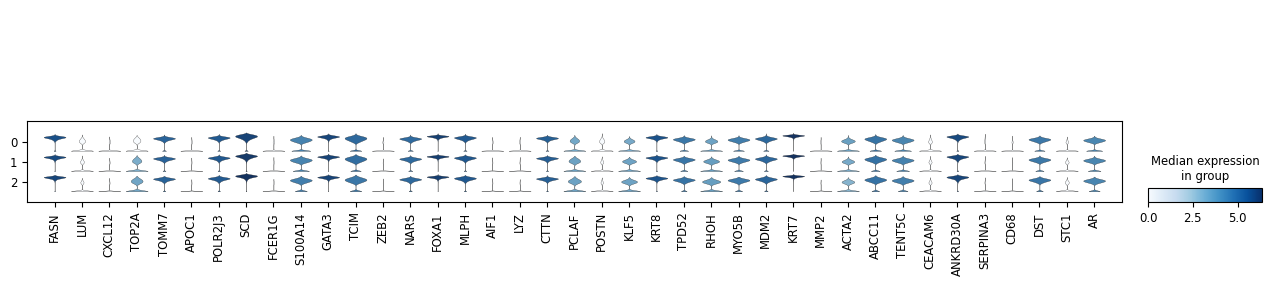

In [43]:
sc.pl.dotplot(adata, marker_genes, groupby='layer');
sc.pl.stacked_violin(adata, marker_genes, groupby='layer', rotation=90);

# GO Enrichment Analysis

In [44]:
#run one time to initialize
# obo_fname = download_go_basic_obo()
# fin_gene2go = download_ncbi_associations()
obo_fname = 'go-basic.obo'
fin_gene2go = 'gene2go'
obodag = GODag(obo_fname)

go-basic.obo: fmt(1.2) rel(2023-03-06) 46,579 Terms


In [45]:
#run one time to initialize
mapper = {}

for key in GeneID2nt_homo:
    mapper[GeneID2nt_homo[key].Symbol] = GeneID2nt_homo[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [46]:
#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:02.754450 342,316 annotations, 20,739 genes, 18,984 GOs, 1 taxids READ: gene2go 


In [47]:
#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_homo.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 82% 16,971 of 20,700 population items found in association

Load CC Ontology Enrichment Analysis ...
 87% 18,094 of 20,700 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,562 of 20,700 population items found in association


In [48]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]


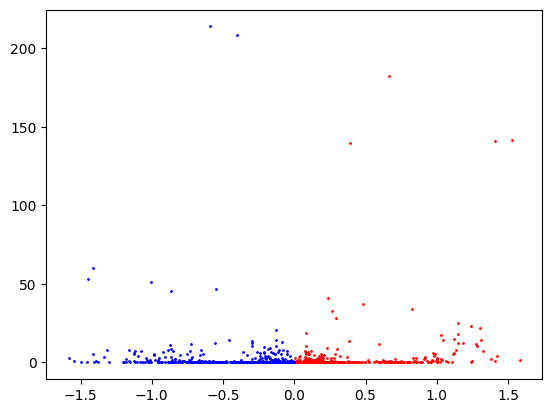

In [49]:
markers = adata.uns['markers']
markers

plt.figure()
plt.scatter(x=markers[markers.lfc>0].lfc,y=markers[markers.lfc>0].pval_adj.apply(lambda x:-np.log10(x)),s=1, c='r')
plt.scatter(x=markers[markers.lfc<=0].lfc,y=markers[markers.lfc<=0].pval_adj.apply(lambda x:-np.log10(x)),s=1, c='b')
plt.show()

In [51]:
ec_markers = markers
ec_markers = ec_markers[(ec_markers.cluster == '0') & (ec_markers.pval_adj < 1e-1) & (ec_markers.lfc  > 1e-9)]
ec_markers

,Gene,scores,pval_adj,lfc,cluster
0,POSTN,25.601656,0.0,1.529828,0
1,LUM,25.51951,0.0,1.406415,0
2,ACTA2,13.191302,0.0,0.484957,0
3,CEACAM6,12.632888,0.0,0.823562,0
4,TCIM,12.329416,0.0,0.26265,0
...,...,...,...,...,...
61,PTPRC,2.283729,0.074546,0.570423,0
62,PRDM1,2.275091,0.075451,0.928616,0
63,IL2RG,2.247308,0.080273,1.246527,0
65,CD93,2.175606,0.0926,0.66665,0


In [52]:
ec_markers.Gene.values

array(['POSTN', 'LUM', 'ACTA2', 'CEACAM6', 'TCIM', 'FCER1G', 'SERPINA3',
       'LYZ', 'KRT8', 'CD68', 'CXCL12', 'ZEB2', 'AIF1', 'MMP2', 'APOC1',
       'CCDC80', 'LDHB', 'PDK4', 'AGR3', 'CLDN4', 'CD4', 'ZEB1', 'S100A4',
       'IGSF6', 'FLNB', 'PDGFRB', 'PECAM1', 'DUSP5', 'CDH1', 'IGF1',
       'CAV1', 'ESR1', 'ADAM9', 'MYLK', 'C1QC', 'FAM107B', 'FBLIM1',
       'FCGR3A', 'CCPG1', 'RUNX1', 'TRAC', 'TACSTD2', 'DSC2', 'HMGA1',
       'CD8A', 'TCF4', 'HAVCR2', 'GLIPR1', 'PDGFRA', 'TRIB1', 'CD14',
       'FBLN1', 'BACE2', 'CCL5', 'C1QA', 'LYPD3', 'LPXN', 'CD3E', 'SVIL',
       'CD86', 'PDE4A', 'PTPRC', 'PRDM1', 'IL2RG', 'CD93', 'SFRP4'],
      dtype=object)

In [53]:
def goea(gene_list):
    print(f'input genes: {len(gene_list)}')

    mapped_genes = []
    for gene in gene_list:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')

    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    go_df = pd.DataFrame(
        list(map(lambda x: [x.GO,
                            x.goterm.name, 
                            x.goterm.namespace, 
                            x.p_uncorrected, 
                            x.p_fdr_bh, 
                            x.ratio_in_study[0], 
                            x.ratio_in_study[1], 
                            GO_items.count(x.GO), 
                            list(map(lambda y: inv_map[y], x.study_items))
                           ],
                 goea_results_sig)
            ),
        columns = ['GO', 
                   'term', 
                   'class', 
                   'p', 
                   'p_corr', 
                   'n_genes',
                   'n_study',
                   'n_go',
                   'study_genes'])

    go_df = go_df[go_df.n_genes > 1]
    
    return go_df

In [54]:
ec_markers.Gene.values

array(['POSTN', 'LUM', 'ACTA2', 'CEACAM6', 'TCIM', 'FCER1G', 'SERPINA3',
       'LYZ', 'KRT8', 'CD68', 'CXCL12', 'ZEB2', 'AIF1', 'MMP2', 'APOC1',
       'CCDC80', 'LDHB', 'PDK4', 'AGR3', 'CLDN4', 'CD4', 'ZEB1', 'S100A4',
       'IGSF6', 'FLNB', 'PDGFRB', 'PECAM1', 'DUSP5', 'CDH1', 'IGF1',
       'CAV1', 'ESR1', 'ADAM9', 'MYLK', 'C1QC', 'FAM107B', 'FBLIM1',
       'FCGR3A', 'CCPG1', 'RUNX1', 'TRAC', 'TACSTD2', 'DSC2', 'HMGA1',
       'CD8A', 'TCF4', 'HAVCR2', 'GLIPR1', 'PDGFRA', 'TRIB1', 'CD14',
       'FBLN1', 'BACE2', 'CCL5', 'C1QA', 'LYPD3', 'LPXN', 'CD3E', 'SVIL',
       'CD86', 'PDE4A', 'PTPRC', 'PRDM1', 'IL2RG', 'CD93', 'SFRP4'],
      dtype=object)

In [55]:
go_df = goea(ec_markers.Gene.values)

input genes: 66
mapped genes: 65

Runing BP Ontology Analysis: current study set of 65 IDs.
 97%     63 of     65 study items found in association
100%     65 of     65 study items found in population(20700)
Calculating 12,449 uncorrected p-values using fisher_scipy_stats
  12,449 terms are associated with 16,971 of 20,700 population items
     861 terms are associated with     63 of     65 study items
  METHOD fdr_bh:
      27 GO terms found significant (< 0.05=alpha) ( 27 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 65 IDs.
 98%     64 of     65 study items found in association
100%     65 of     65 study items found in population(20700)
Calculating 1,777 uncorrected p-values using fisher_scipy_stats
   1,777 terms are associated with 18,094 of 20,700 population items
     150 terms are associated with

In [56]:
go_df['per'] = go_df.n_genes/go_df.n_go

In [57]:
go_df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per
0,GO:0030335,positive regulation of cell migration,biological_process,2.759610e-13,3.435439e-09,13,65,247,"[PDGFRA, PDGFRB, AIF1, CEACAM6, CCL5, ADAM9, C...",0.052632
1,GO:0042102,positive regulation of T cell proliferation,biological_process,2.696169e-08,1.678230e-04,6,65,59,"[HAVCR2, AIF1, CD86, CCL5, CD3E, PTPRC]",0.101695
2,GO:0007166,cell surface receptor signaling pathway,biological_process,4.944443e-08,2.051779e-04,9,65,289,"[CD14, FCGR3A, CD86, CD3E, IGSF6, PECAM1, CD4,...",0.031142
3,GO:0032743,positive regulation of interleukin-2 production,biological_process,6.768685e-08,2.106584e-04,5,65,34,"[CD86, CD3E, CD4, PTPRC, RUNX1]",0.147059
4,GO:0070374,positive regulation of ERK1 and ERK2 cascade,biological_process,2.805600e-07,6.985382e-04,8,65,219,"[HAVCR2, PDGFRA, PDGFRB, CCL5, IGF1, CD4, ACTA...",0.036530
5,GO:0042110,T cell activation,biological_process,6.667384e-07,1.383371e-03,5,65,53,"[CD86, CD3E, CD4, PTPRC, CD8A]",0.094340
6,GO:0032753,positive regulation of interleukin-4 production,biological_process,1.256521e-06,2.234632e-03,4,65,27,"[CD3E, HAVCR2, CD86, FCER1G]",0.148148
7,GO:0018108,peptidyl-tyrosine phosphorylation,biological_process,2.335759e-06,3.634733e-03,5,65,68,"[PDGFRA, PDGFRB, CD3E, CD4, PTPRC]",0.073529
8,GO:0010863,positive regulation of phospholipase C activity,biological_process,3.490853e-06,4.828625e-03,3,65,10,"[ESR1, PDGFRA, PDGFRB]",0.300000
9,GO:0006955,immune response,biological_process,4.479282e-06,5.576258e-03,8,65,420,"[FCGR3A, IL2RG, C1QC, CD86, CXCL12, IGSF6, CD4...",0.019048


In [58]:
go_df_top15 = go_df[:15]

In [59]:
go_df_top15

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per
0,GO:0030335,positive regulation of cell migration,biological_process,2.759610e-13,3.435439e-09,13,65,247,"[PDGFRA, PDGFRB, AIF1, CEACAM6, CCL5, ADAM9, C...",0.052632
1,GO:0042102,positive regulation of T cell proliferation,biological_process,2.696169e-08,1.678230e-04,6,65,59,"[HAVCR2, AIF1, CD86, CCL5, CD3E, PTPRC]",0.101695
2,GO:0007166,cell surface receptor signaling pathway,biological_process,4.944443e-08,2.051779e-04,9,65,289,"[CD14, FCGR3A, CD86, CD3E, IGSF6, PECAM1, CD4,...",0.031142
3,GO:0032743,positive regulation of interleukin-2 production,biological_process,6.768685e-08,2.106584e-04,5,65,34,"[CD86, CD3E, CD4, PTPRC, RUNX1]",0.147059
4,GO:0070374,positive regulation of ERK1 and ERK2 cascade,biological_process,2.805600e-07,6.985382e-04,8,65,219,"[HAVCR2, PDGFRA, PDGFRB, CCL5, IGF1, CD4, ACTA...",0.036530
5,GO:0042110,T cell activation,biological_process,6.667384e-07,1.383371e-03,5,65,53,"[CD86, CD3E, CD4, PTPRC, CD8A]",0.094340
6,GO:0032753,positive regulation of interleukin-4 production,biological_process,1.256521e-06,2.234632e-03,4,65,27,"[CD3E, HAVCR2, CD86, FCER1G]",0.148148
7,GO:0018108,peptidyl-tyrosine phosphorylation,biological_process,2.335759e-06,3.634733e-03,5,65,68,"[PDGFRA, PDGFRB, CD3E, CD4, PTPRC]",0.073529
8,GO:0010863,positive regulation of phospholipase C activity,biological_process,3.490853e-06,4.828625e-03,3,65,10,"[ESR1, PDGFRA, PDGFRB]",0.300000
9,GO:0006955,immune response,biological_process,4.479282e-06,5.576258e-03,8,65,420,"[FCGR3A, IL2RG, C1QC, CD86, CXCL12, IGSF6, CD4...",0.019048


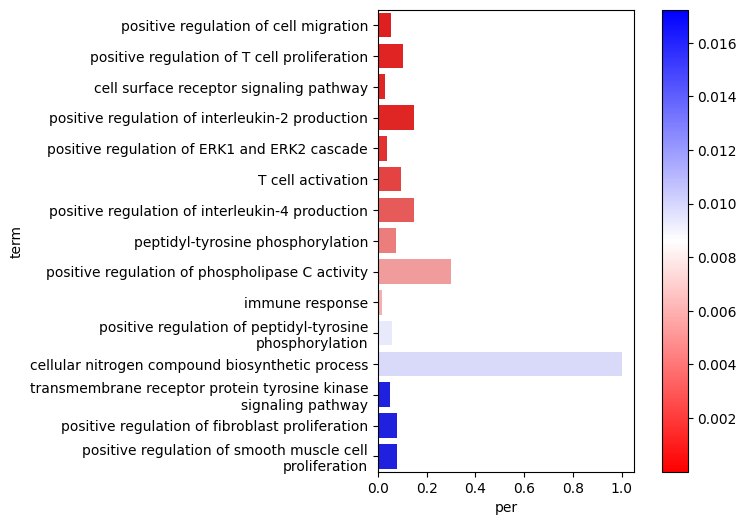

In [60]:
fig, axes = plt.subplots(ncols=2, figsize = (4, 6), width_ratios=[10, 1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin = go_df_top15.p_corr.min(), vmax = go_df_top15.p_corr.max())
cm_mapper = cm.ScalarMappable(norm = norm, cmap = cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(axes[1], cmap = cmap, norm = norm, orientation = 'vertical')
sns.barplot(data = go_df_top15, x = 'per', y = 'term', palette = cm_mapper.to_rgba(go_df_top15.p_corr.values), ax=axes[0])
axes[0].set_yticklabels([textwrap.fill(e, 50) for e in go_df_top15['term']])
plt.show();

# GO Enrichment Spatial Differential Analysis